## Определение перспективного тарифа для телеком компании
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


|                                          | Тариф «Смарт»                     | Тариф «Ультра»                    |
|------------------------------------------|-----------------------------------|-----------------------------------|
| **Ежемесячная плата**                      | 550 рублей                        | 1950 рублей                       |
| **Включено**                                 | 500 минут разговора               | 3000 минут разговора              |
|                                          | 50 сообщений                      | 1000 сообщений                    |
|                                          | 15 Гб интернет-трафика            | 30 Гб интернет-трафика            |
|  **Стоимость сверх тарифного пакета** | минута разговора: 3 рубля         | минута разговора: 1 рубль         |
|                                          | сообщение: 3 рубля                | сообщение: 1 рубль                |
|                                          | 1 Гб интернет-трафика: 200 рублей | 1 Гб интернет-трафика: 150 рублей |
|                                          |                                   |                                   |

### Шаг 1. Откройте файл с данными и изучите общую информацию


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# для просмотра офлайн
'''calls = pd.read_csv('datasets/calls.csv')
internet = pd.read_csv('datasets/internet.csv')
messages = pd.read_csv('datasets/messages.csv')
tariffs = pd.read_csv('datasets/tariffs.csv')
users = pd.read_csv('datasets/users.csv')'''
# для просмотра онлайн на я.практикуме
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Рассмотрим каждый из датасетов:


#### Звонки

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.**

Значит, `duration` = 0 – это что-то странное.

Сколько таких звонков:

In [4]:
len(calls[calls.duration < 1.])/len(calls) * 100

23.655155053872768

~ 24% . Кажется, при выгрузке перепутали `np.ceil()` и `np.floo()`

In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Уникальных id в таблице:

In [7]:
len(calls['user_id'].unique())

492

In [8]:
calls.duplicated().sum()

0

___
#### Интернет

In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
36083,36083,1126_30,649.59,2018-04-07,1126
84713,84713,1288_26,262.54,2018-11-27,1288
137798,137798,1464_22,69.81,2018-12-16,1464
43357,43357,1149_357,79.38,2018-06-24,1149
80692,80692,1272_84,153.00,2018-10-02,1272


`mb_used`, а по тарифу считаются gb. 

Не забыть перевести в гигабайты для дальнейшего анализа !

In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [12]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Доля абонентов с нулевым показателем потраченных Мб:

In [13]:
len(internet[internet.mb_used == 0])/len(internet) * 100

13.118155773916303

Уникальных id в таблице:

In [14]:
len(internet['user_id'].unique())

497

In [15]:
internet.duplicated().sum()

0

#### Сообщения

In [16]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [17]:
messages.sample(5)

,id,message_date,user_id
44443,1193_199,2018-09-01,1193
106205,1430_280,2018-12-23,1430
110324,1447_9,2018-12-19,1447
99511,1407_15,2018-12-24,1407
110355,1447_40,2018-12-11,1447


In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [20]:
messages.duplicated().sum()

0

In [21]:
len(messages['user_id'].unique())

426

А всего 500 `users`. Кто-то вообще не использует смс.

#### Тарифы

In [22]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [23]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [24]:
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


#### Пользователи

In [25]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [26]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
17,1017,73,NaN,Краснодар,Мария,Аленникова,2018-05-22,smart
26,1026,32,NaN,Мурманск,Евгений,Бородин,2018-10-06,smart
170,1170,69,NaN,Новосибирск,Вадим,Козлов,2018-12-20,smart
350,1350,40,NaN,Омск,Варвара,Козырева,2018-08-30,ultra
243,1243,74,NaN,Пермь,Артём,Леонтьев,2018-06-01,ultra


In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Доля пропущенных значений в `churn_date`:

In [28]:
users['churn_date'].isnull().sum()/len(users)*100

92.4

In [29]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [30]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [31]:
users.duplicated().sum()

0

In [32]:
len(users['user_id'].unique())

500

In [33]:
426/500

0.852

### Вывод

#### Звонки

✅ без пропущенных значений

0️⃣ нули в `duration` (~24%), исходя из особенностей оператора, надо заменить единицей

🔢 `duration` перевести в целочисленный формат

🤓 492 уникальных id из 500 существующих

👯 дубликатов не обнаружено


#### Интернет

✅ без пропущенных значений

0️⃣ 13% потратило 0 Мб. Настоящий интернет детокс. Однако, это надо будет исправить.

🔢 `mb_used` -> `gb_used` согласно описанию тарифа

🤓 497 уникальных id из 500 существующих

👯 дубликатов не обнаружено

#### Сообщения

✅ без пропущенных значений

0️⃣ 74 абонента (~9%) отсутствуют в датасете, значит, не использовали смс

🤓 426 уникальных id из 500 существующих

👯 дубликатов не обнаружено

#### Тарифы

✅ без пропущенных значений

🔢 `mb_per_month_included` натолкнул на мысль, что можно было бы не переводить в Гб `internet[mb_used]`.

    Но всё-таки удобнее должно быть в Гб. Почти как расстояние из метров - в километры.

👯 дубликатов не обнаружено

#### Пользователи

🆘 92.4% пропущенных в `churn_date`. Значит, тариф этой доли пользователей ещё действовал на момент выгрузки.

✅ И даже минимальный возраст 18, всё по правилам 

🤓 500 уникальных id : 351 пользователь smart, 149 - ultra

👯 дубликатов не обнаружено

### Шаг 2. Подготовка данных

#### Приведение данных к нужным типам

Округлим `internet['mb_used']` и `calls['duration']` в бóльшую сторону и приведём к целочисленному типу:

In [34]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

In [35]:
internet.sample()

,Unnamed: 0,id,mb_used,session_date,user_id
14047,14047,1049_31,895,2018-11-29,1049


In [36]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [37]:
calls.sample()

,id,call_date,duration,user_id
147393,1375_224,2018-10-20,0,1375


Все столбцы с датами приведём к формату `%Y-%m-%d`

In [38]:
date = '%Y-%m-%d'

def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=date)

In [39]:
to_datetime(users, ['reg_date', 'churn_date'])
to_datetime(calls, ['call_date'])
to_datetime(messages, ['message_date'])
to_datetime(internet, ['session_date'])

#### Найдите и исправьте ошибки в данных

Звонки длиной 0 округлим до 1. Интернет - тоже. 

Такова задумка оператора.

In [40]:
calls['duration'] = calls['duration'].where(calls['duration'] > 1,  1)

Остались ли нули в звонках?

In [41]:
len(calls[calls['duration']==0])

0

In [42]:
internet['mb_used'] = internet['mb_used'].where(internet['mb_used'] > 1,  1)

Остались ли нули в интернете?

In [43]:
len(internet[internet['mb_used']==0])

0

#### Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;


In [44]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [45]:
calls.sample(5)

,id,call_date,duration,user_id,month
200777,1495_164,2018-11-22,11,1495,11
177671,1439_218,2018-11-28,10,1439,11
89116,1224_33,2018-07-05,1,1224,7
200854,1495_241,2018-10-13,9,1495,10
186041,1459_178,2018-12-21,1,1459,12


Функция для более быстрого создания сводных табличек

In [46]:
def month_pivot(df, ind, val, func):
    return df.pivot_table(
    index=ind,
    values=val,
    aggfunc=func
    )

Датафрейм, в который будем мёрджить

In [47]:
costs = pd.DataFrame()

In [48]:
calls_by_month = month_pivot(calls, ['month', 'user_id'], 'duration', ['count', 'sum'])
calls_by_month.sample(5)

,,count,sum
,,duration,duration
month,user_id,,
6,1130,79,661
12,1448,50,477
6,1429,31,211
10,1204,41,330
5,1064,56,443


In [49]:
costs['user_id'] = pd.DataFrame(calls_by_month.to_records())['user_id']
costs['month'] = pd.DataFrame(calls_by_month.to_records())['month']
costs['calls'] = pd.DataFrame(calls_by_month.to_records()).iloc[:, 2]
costs['minutes'] = pd.DataFrame(calls_by_month.to_records()).iloc[:, 3]

- количество отправленных сообщений по месяцам;

In [50]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [51]:
messages.sample(5)

,id,message_date,user_id,month
22492,1093_374,2018-12-10,1093,12
63819,1277_496,2018-04-26,1277,4
57902,1253_411,2018-10-27,1253,10
121444,1491_243,2018-10-12,1491,10
31628,1142_147,2018-07-23,1142,7


In [52]:
messages_by_month = month_pivot(messages, ['month', 'user_id'], 'id', ['count'])
messages_by_month.sample(5)

,,count
,,id
month,user_id,
7,1251,90
6,1009,14
12,1206,8
3,1454,20
6,1173,3


In [53]:
costs = costs.merge(pd.DataFrame(messages_by_month.to_records()), on=['user_id', 'month'], how='outer')

- объем израсходованного интернет-трафика по месяцам;

In [54]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [55]:
internet_by_month = month_pivot(internet, ['month', 'user_id'], 'mb_used', 'sum')
internet_by_month.sample(5)

,,mb_used
month,user_id,
11,1353,16597
7,1076,26884
9,1135,19495
8,1482,19250
10,1301,19673


In [56]:
costs = costs.merge(pd.DataFrame(internet_by_month.to_records()), on=['user_id', 'month'], how='outer')

- помесячную выручку с каждого пользователя.

In [57]:
costs = costs.rename(columns={"('count', 'id')": 'messages'})

In [58]:
costs.head()

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15.0,99.0,7.0,2730.0
1,1032,1,61.0,397.0,38.0,24158.0
2,1045,1,1.0,9.0,5.0,2348.0
3,1055,1,64.0,568.0,30.0,17115.0
4,1071,1,24.0,200.0,16.0,15625.0


In [59]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3174 non-null float64
minutes     3174 non-null float64
messages    2717 non-null float64
mb_used     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


Появились пропуски из-за того, что не все пользователи пользовались звонками/интернетом/сообщениями на протяжении месяца. 

Из-за пропусков при соединении датафреймов всё перешло в формат float.

Такие пропуски заполним нулями и всех приведем к int

In [60]:
for col in ['calls', 'minutes', 'messages', 'mb_used']:
    costs[col] = costs[col].fillna(0).astype('int64')

In [61]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3214 non-null int64
minutes     3214 non-null int64
messages    3214 non-null int64
mb_used     3214 non-null int64
dtypes: int64(6)
memory usage: 175.8 KB


Добавим в датафрейм информацию о пользователях и тарифах

In [62]:
costs = costs.merge(users, on='user_id', how='left')

Переименуем `tariff_name` в `tariff`, чтобы далее мёрджить

In [63]:
tariffs = tariffs.rename(columns={"tariff_name": 'tariff'})

In [64]:
costs = costs.merge(tariffs, on='tariff', how='left')

In [65]:
costs.head()

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1005,1,15,99,7,2730,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3
1,1032,1,61,397,38,24158,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,50,15360,500,550,200,3,3
2,1045,1,1,9,5,2348,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,50,15360,500,550,200,3,3
3,1055,1,64,568,30,17115,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,50,15360,500,550,200,3,3
4,1071,1,24,200,16,15625,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,50,15360,500,550,200,3,3


Бесплатный лимит вычитаем из общего количества минут/сообщений/мб.

Положительные значения будут означать перерасход

In [66]:
def delta(df, current, tariff, new_col):
    df[new_col] = - df[tariff] + df[current]

In [67]:
delta(costs, 'minutes', 'minutes_included', 'minutes_over')
delta(costs, 'messages', 'messages_included', 'messages_over')
delta(costs, 'mb_used', 'mb_per_month_included', 'mb_used_over')

Перерасход умножаем на значения цен, предписанные тарифным планом за превышение лимита.

Функция, которая справится с этим быстрее:

In [68]:
def monthly_revenue(row):
    
    minutes_price = 0
    messages_price = 0
    mb_used_price = 0
    
    # стоимость дополнительных минут
    if row['minutes_over'] > 0:
        minutes_price = row['minutes_over'] * row['rub_per_minute']

    # стоимость дополнительных сообщений
    if row['messages_over'] > 0:
        messages_price = row['messages_over'] * row['rub_per_message']

    # стоимость дополнительного трафика
    if row['mb_used_over'] > 0:
        mb_used_price = (row['mb_used_over'] / 1024) * row['rub_per_gb']
    
    return minutes_price + messages_price + mb_used_price


Финальный столбец – со всеми тратами (плановый тариф + превышение лимита)

In [69]:
costs['rub_monthly_fee_over'] = costs.apply(monthly_revenue, axis=1)
costs['rub_monthly_fee_total'] = costs['rub_monthly_fee'] + costs['rub_monthly_fee_over']

Оставляем только необходимые столбцы:

In [70]:
costs = pd.DataFrame(
    costs[['month', 'tariff', 'user_id', 'city',
           'calls', 'minutes', 'messages', 'mb_used',
           'minutes_over', 'messages_over', 'mb_used_over',
           'rub_monthly_fee_over', 'rub_monthly_fee_total']]
)

In [71]:
costs.head()

,month,tariff,user_id,city,calls,minutes,messages,mb_used,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1,smart,1005,Набережные Челны,15,99,7,2730,-401,-43,-12630,0.000000,550.000000
1,1,smart,1032,Ульяновск,61,397,38,24158,-103,-12,8798,1718.359375,2268.359375
2,1,smart,1045,Улан-Удэ,1,9,5,2348,-491,-45,-13012,0.000000,550.000000
3,1,smart,1055,Казань,64,568,30,17115,68,-20,1755,546.773438,1096.773438
4,1,smart,1071,Омск,24,200,16,15625,-300,-34,265,51.757812,601.757812


In [72]:
smart_costs = costs.query("tariff == 'smart'")
len(smart_costs.groupby('user_id'))

350

In [73]:
ultra_costs = costs.query("tariff == 'ultra'")
len(ultra_costs.groupby('user_id'))

148

А в сумме было 500. 

2 пользователя куда-то потерялись 👐🏻

### Шаг 3. Проанализируем данные

#### Поведение клиентов оператора, исходя из выборки

In [74]:
vals = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total']

Построим таблицу относительно каждого тарифа по месяцам

In [75]:
monthly_costs = month_pivot(costs, ['tariff', 'month'], vals, 'mean')
monthly_costs.head(10)

mb_used   messages     minutes  rub_monthly_fee_over  \
tariff month                                                              
smart  1       8528.588235  18.235294  209.647059            154.895910   
       2      11617.344828  24.086207  306.310345            262.159752   
       3      15131.207792  31.857143  400.532468            583.213271   
       4      13486.080357  30.741071  377.000000            384.781878   
       5      15832.751773  33.773050  398.404255            611.004377   
       6      15822.445122  33.402439  406.701220            614.601038   
       7      15771.398010  33.751244  419.288557            635.629392   
       8      16640.212766  33.638298  433.191489            726.647008   
       9      16332.615385  33.638462  440.080769            667.753456   
       10     16786.853741  33.765306  438.295918            773.870669   

              rub_monthly_fee_total  
tariff month                         
smart  1                 704.895910  
       2                 812.159752  
       3                1133.213271  
       4                 934.781878  
       5                1161.004377  
       6                1164.601038  
       7                1185.629392  
       8                1276.647008  
       9                1217.753456  
       10               1323.870669

Для пользователей тарифа Смарт:

In [76]:
monthly_costs.loc['smart']

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,8528.588235,18.235294,209.647059,154.895910,704.895910
2,11617.344828,24.086207,306.310345,262.159752,812.159752
3,15131.207792,31.857143,400.532468,583.213271,1133.213271
4,13486.080357,30.741071,377.000000,384.781878,934.781878
5,15832.751773,33.773050,398.404255,611.004377,1161.004377
6,15822.445122,33.402439,406.701220,614.601038,1164.601038
7,15771.398010,33.751244,419.288557,635.629392,1185.629392
8,16640.212766,33.638298,433.191489,726.647008,1276.647008
9,16332.615385,33.638462,440.080769,667.753456,1217.753456


Для пользователей тарифа Ультра:

In [77]:
monthly_costs.loc['ultra']

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,13154.666667,33.777778,440.888889,0.000000,1950.000000
2,11788.333333,21.958333,304.666667,23.095703,1973.095703
3,17553.513514,32.297297,503.081081,54.254645,2004.254645
4,16845.254545,31.563636,470.072727,45.474077,1995.474077
5,19383.194030,37.850746,524.865672,105.022738,2055.022738
6,18943.928571,41.726190,492.428571,82.109724,2032.109724
7,20516.571429,49.846154,560.296703,158.562092,2108.562092
8,19595.878505,48.439252,524.570093,121.230195,2071.230195
9,19224.043478,52.286957,553.643478,63.776749,2013.776749


**Сколько минут разговора, сколько сообщений и какой объём интернет-трафика 
 требуется пользователям каждого тарифа в месяц?**

Средние значения в месяц вне зависимости от тарифа

In [78]:
month_pivot(monthly_costs, 'tariff', vals, 'mean')

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
tariff,,,,,
smart,15085.107080,31.413211,397.374228,595.673948,1145.673948
ultra,18224.477581,43.714983,509.356551,88.972927,2038.972927


- У "Смарта" выше среднее превышение стоимости, значит, они чаще выходят за лимит, несмотря на то, что суммарное среднее у них меньше. Это может быть на руку оператору для проведения маркетинговых кампаний.
- У "Ультра" выше прибыль. Вероятно, люди платят больше, чтобы наверняка уложиться в лимиты, но для пользователей это чревато неиспользованными остатками трафика. Однако, оператору этот тариф выгоднее.

Ради интереса посмотрим, как различаются "Смарт" и "Ультра" в Москве и неМоскве по месяцам

In [79]:
month_moscow_smart = month_pivot(costs.loc[(costs['city'] == 'Москва') & (costs['tariff'] =='smart')],  ['month'], vals, 'mean')
month_moscow_ultra = month_pivot(costs.loc[(costs['city'] == 'Москва') & (costs['tariff'] =='ultra')],  ['month'], vals, 'mean')

In [80]:
month_not_moscow_smart = month_pivot(costs.loc[(costs['city'] != 'Москва') & (costs['tariff'] =='smart')],  ['month'], vals, 'mean')
month_not_moscow_ultra = month_pivot(costs.loc[(costs['city'] != 'Москва') & (costs['tariff'] =='ultra')],  ['month'], vals, 'mean')

In [81]:
cols = ['mb_used', 'messages', 'minutes', 'rub_monthly_fee_total']

In [82]:
def plots(cols):
    for col in cols:
        plt.title(col)
        plt.xlabel('no. of month')
        plt.plot(month_moscow_smart[col], label='Msc_Smart')
        plt.plot(month_moscow_ultra[col], label='Msc_Ultra')
        plt.plot(month_not_moscow_smart[col], label='notMsc_Smart')
        plt.plot(month_not_moscow_ultra[col], label='notMsc_Ultra')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

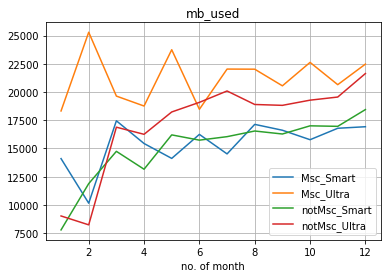

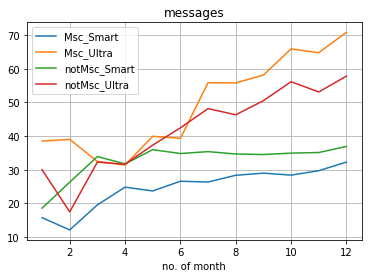

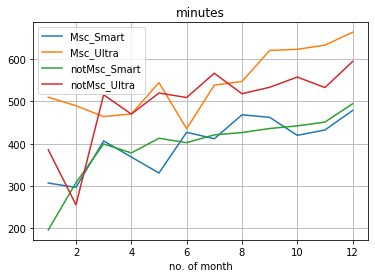

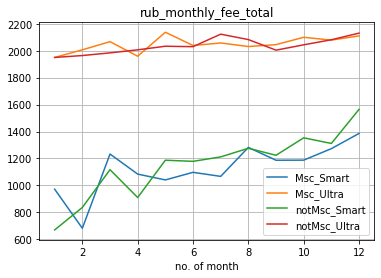

In [83]:
plots(cols)

- Как оказалось, больше всего трафика (за исключением минут) тратят пользователи "Ультра" из Москвы. Они же почти всегда больше всех платят. Значит, и превышают.

- Пользователи "Смарт" из регионов практически всегда опережают московских абонентов этого трафика и платят больше.

In [84]:
means = month_pivot(costs,  ['city'], vals, 'mean')
means

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
city,,,,,
Архангельск,17306.666667,19.000000,426.500000,686.792969,1236.792969
Астрахань,16712.266667,49.033333,364.733333,589.919792,1373.253125
Балашиха,14118.687500,9.031250,500.250000,437.391357,1424.891357
Барнаул,12872.388889,6.111111,621.666667,72.793837,1478.349392
Белгород,12923.466667,33.800000,356.733333,177.833333,727.833333
...,...,...,...,...,...
Челябинск,17988.557692,46.326923,437.019231,546.593299,1688.900992
Череповец,16901.857143,74.714286,548.000000,1258.291295,2108.291295
Чита,13193.888889,29.777778,517.388889,661.271267,1211.271267


По средним значениям выручки пользователей Москвы и регионов видно, что в целом разница не велика. 

Пользователи отправляют примерно одинаковое количество смс и звонят примерно одинаковое количество минут. 

В Москве чуть больше потребляют трафика – это ожидаемо с учетом покрытия и скорости. 

При проверке гипотез узнаем, насколько случайны полученные значения.

___


#### Посчитаем среднее количество, дисперсию и стандартное отклонение.

Т.к. нормальное распредление определяют среднее и дисперсия,то они дадут понять, насколько шумные данные.

In [85]:
def analysis(cols):
    for col in cols:
        print(col)
        print('Среднее smart:', smart_costs[col].mean())
        print('Среднее ultra:', ultra_costs[col].mean())
        print()
        
        print('Дисперсия smart:', np.var(smart_costs[col], ddof=1))
        print('Дисперсия ultra:', np.var(ultra_costs[col], ddof=1))
        print()
        
        print('Стандартное отклонение smart:', np.sqrt(np.var(smart_costs[col], ddof=1)))
        print('Стандартное отклонение ultra:', np.sqrt(np.var(ultra_costs[col], ddof=1)))
        print()
        
        plt.hist(smart_costs[col], bins=50, label='smart', alpha=0.5)
        plt.hist(ultra_costs[col], bins=50, label='ultra', alpha=0.5)
        plt.title('Smart / Ultra ' + col + ' per month')
        plt.ylabel('Frequency')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
        print('====================================')

minutes
Среднее smart: 429.45087483176314
Среднее ultra: 540.7796954314721

Дисперсия smart: 37974.77462782491
Дисперсия ultra: 106105.72682307809

Стандартное отклонение smart: 194.87117444051316
Стандартное отклонение ultra: 325.73874013245353



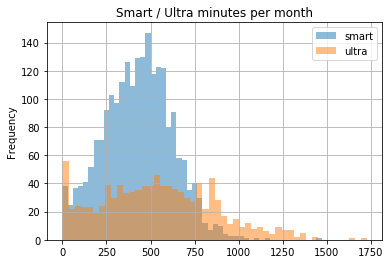

mb_used
Среднее smart: 16237.184387617766
Среднее ultra: 19488.703553299492

Дисперсия smart: 34571991.094801076
Дисперсия ultra: 101951580.68642023

Стандартное отклонение smart: 5879.795157554477
Стандартное отклонение ultra: 10097.107540598952



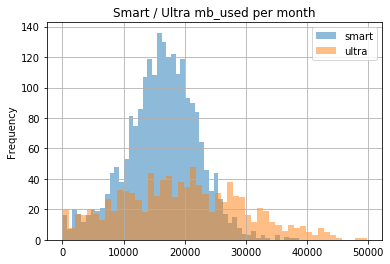

messages
Среднее smart: 33.384028712427096
Среднее ultra: 49.36345177664975

Дисперсия smart: 796.8129584480091
Дисперсия ultra: 2285.2661425446818

Стандартное отклонение smart: 28.227875556761425
Стандартное отклонение ultra: 47.8044573501748



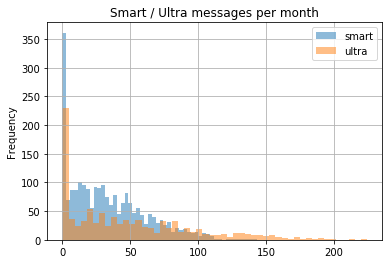

In [86]:
analysis(['minutes', 'mb_used', 'messages'])

Все распределения сдвинуты влево, но это можно поправить нормировкой, непосредственно при подготовке деанных перед проверкой гипотез

### Шаг 4. Проверка гипотез

Готовим данные по правилу трёх мю!

$Low\_Limit = 3\cdot\mu - \sigma$

$Upper\_Limit = 3\cdot\mu + \sigma$

Все данные за этими границами в массив для проверки гипотез не войдут

In [87]:
def out_limits(dataset, tariff, case):
    
    mu = np.mean(dataset)
    sigma = np.std(dataset)
    limit = sigma * 3

    LL = mu - limit # lower limit
    UL = mu + limit # upper limit
    
    if case == 0:
        plt.title(tariff)
        costs.loc[costs['tariff']==tariff]['rub_monthly_fee_total'].hist(color='c', edgecolor='k', alpha=0.65)
        #plt.axvline(LL,color='k', linestyle='dashed', linewidth=1)
        plt.axvline(UL,color='k', linestyle='dashed', linewidth=1)
    
    elif case == 1:
        plt.title('не ' + tariff)
        costs.loc[costs['city'] != tariff]['rub_monthly_fee_total'].hist(color='c', edgecolor='k', alpha=0.65)
        #plt.axvline(LL,color='k', linestyle='dashed', linewidth=1)
        plt.axvline(UL,color='k', linestyle='dashed', linewidth=1)
        
    elif case == 2:
        plt.title(tariff)
        costs.loc[costs['city'] == tariff]['rub_monthly_fee_total'].hist(color='c', edgecolor='k', alpha=0.65)
        #plt.axvline(LL,color='k', linestyle='dashed', linewidth=1)
        plt.axvline(UL,color='k', linestyle='dashed', linewidth=1)
        
    return UL, LL

Подготовка для тарифа Смарт

Чёрный пунктир обозначает верхнюю границу, за которой данные для проверки гипотез не сохранялись

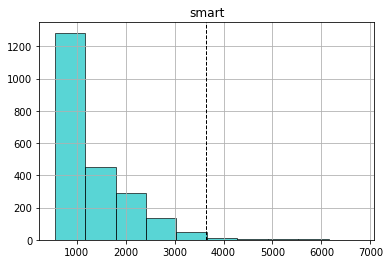

In [88]:
UL_smart = out_limits(costs.loc[costs['tariff']=='smart']['rub_monthly_fee_total'], 'smart', 0)[0]
df_smart = costs.loc[(costs['tariff']=='smart') & (costs['rub_monthly_fee_total']<UL_smart)]['rub_monthly_fee_total']
df_smart = df_smart.to_numpy()

Подготовка для тарифа Ультра

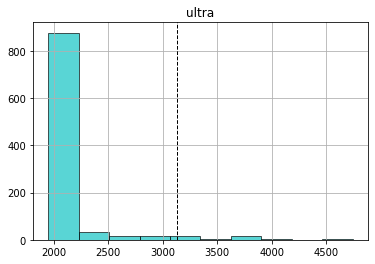

In [89]:
UL_ultra = out_limits(costs.loc[costs['tariff']=='ultra']['rub_monthly_fee_total'], 'ultra', 0)[0]
df_ultra = costs.loc[(costs['tariff']=='ultra') & (costs['rub_monthly_fee_total']<UL_ultra)]['rub_monthly_fee_total']
df_ultra = df_ultra.to_numpy()

Подготовка данных по Москве

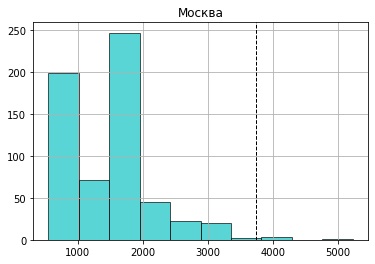

In [90]:
UL_moscow = out_limits(costs.loc[costs['city']=='Москва']['rub_monthly_fee_total'], 'Москва', 2)[0]
df_moscow = costs.loc[(costs['city']=='Москва') & (costs['rub_monthly_fee_total']<UL_moscow)]['rub_monthly_fee_total']
df_moscow = df_moscow.to_numpy()

Подготовка данных за пределами Москвы

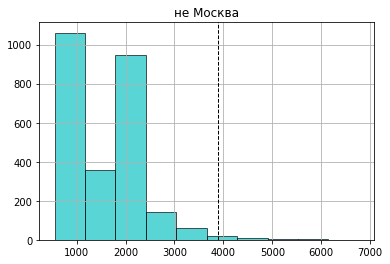

In [91]:
UL_not_moscow = out_limits(costs.loc[costs['city']!='Москва']['rub_monthly_fee_total'], 'Москва', 1)[0]
df_not_moscow = costs.loc[(costs['city']=='Москва') & (costs['rub_monthly_fee_total']<UL_moscow)]['rub_monthly_fee_total']
df_not_moscow = df_not_moscow.to_numpy()

Гипотеза о равенстве средних двух генеральных совокупностей


Будем использовать t-тест, т.к. сравниваемые выборки независимы между собой.

In [92]:
def hypothesis(arr1, arr2):
    alpha = 0.01
    res = st.ttest_ind(arr1, arr2)

    print('p-значение:', res.pvalue)

    if (res.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

#### 🟢 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [93]:
print('Средняя выручка пользователей тарифов «Смарт»:', month_pivot(costs, ['tariff'], vals, 'mean')['rub_monthly_fee_total'][0])
print('Средняя выручка пользователей тарифов «Ультра»:', month_pivot(costs, ['tariff'], vals, 'mean')['rub_monthly_fee_total'][1])

Средняя выручка пользователей тарифов «Смарт»: 1251.4096673115746
Средняя выручка пользователей тарифов «Ультра»: 2060.591390387056


Нулевая гипотеза $H_0$:

Средняя выручка пользователей тарифов "Ультра" и "Смарт" **не различается**
___
Альтернативная гипотеза $H_1$:

Средняя выручка пользователей тарифов "Ультра" и "Смарт" **различается**

___
В качестве порогового значения в обоих случаях выбираем $\alpha = 0.01$, для бОльшей чувствительности и, к тому же, наши выборки не очень маленькие ( > 100 экземпляров )

In [94]:
hypothesis(df_ultra, df_smart)

p-значение: 7.0360483529723424e-208
Отвергаем нулевую гипотезу


Средняя выручка по тарифам не одинакова, и нулевая вероятность говорит о том, что случайно получить такое отличие в значениях невозможно.

Следовательно,альтернативная гипотеза подтвердилась.

#### 🔴 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [95]:
print('Средняя выручка пользователей из Москвы:', means['rub_monthly_fee_total'][1])
print('Средняя выручка пользователей регионов:', means['rub_monthly_fee_total'][0])

Средняя выручка пользователей из Москвы: 1373.253125
Средняя выручка пользователей регионов: 1236.79296875


Нулевая гипотеза $H_0$:

Cредняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов
___

Альтернативная гипотеза $H_1$:

Cредняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов

In [96]:
hypothesis(df_moscow, df_not_moscow)

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


p-value показывает слишком большую вероятность, чтобы делать вывод о значимом различии между средними выручками. 

Таким образом, средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов, и нулевая гипотеза подтвердилась.

### Шаг 5. Общий вывод

Для исследования были предоставлены 5 датасетов с 500 уникальными пользователями тарифов "Ультра" и "Смарт" и данными о том, как они пользовались услугами оператора.

Любопытно, что в данных были незашифрованные имена/фамилии и города, где проживают пользователи. Такие данные нужно шифровать.

Были найдены такие аномалии, как звонки длиной в 0 минут и расходованный интернет в количестве 1 Мб.
Эти пропуски было решено заполнить единицами – как если бы оператор округлял значения меньше минуты/мегабайта наверх. Скорее всего, при выгрузке данных произошла ошибка из-за путаницы `np.floo()` и `np.ceil()`.

Данные были обработаны, даты приведены к единому формату.
Все необходимые данные сведены в одну таблицу `costs` для дальнейшего анализа.

После объединения данных в `costs` возникли пропуски – значения, зафиксированные ещё в начале в таблицах со звонками, интернетом, сообщениями – там не хватало пользователей до 500.
    Такие пропуски заполнили нулями, чтобы они наверняка отличались и ни на что не влияли. Так же перевели всё обратно в `int`, т.к. из-за пропусков возник `float`.

Люди, использующие разные тарифы, ведут себя по-разному. Значит, разделение на тарифы было верным. Но это можно оптимизировать, потому что количество переплат в Смарте может привести либо к оттоку клиентов, либо к переходу на "Ультра".

Самые неизрасходованные – пакеты смс в "Ультра", оператору можно было бы сократить количество смс, включенных в тариф.

Прибыль из Москвы и регионов практически не отличается, потому что связь – это повседневная необходимость, а не показатель уровня. Хотя пользователи "Утра" не из Москвы тратят меньше. (Но из "Смарта" – больше).

Так же из исследования стало известно, что выручка "Смарт" и "Ультра" различается. У "Ультра" она больше, это нам удалось подтвердить с помощью t-теста Стьюдента.

Итого, "Ультра" приносит больше прибыли и выглядит перспективнее, особенно если оптимизировать пакетные предложения (уменьшить смс и увеличить интернет).